In [1]:
from copulae1 import *
import os
import plotly.express as px
import plotly.figure_factory as ff

import plotly.graph_objects as go

In [71]:
data = pd.read_csv('../data/btc future and reference rate/coingecko_future.csv')
brr = data.iloc[:,4]
btc = data.iloc[:,5]

u = ECDF(brr)(brr)
v = ECDF(btc)(btc)

In [2]:
import json
with open('../src/configs/config_coingecko_future_v3_MM.json','r') as file:
    config = json.load(file)
config
data_name = config['data_name']
calibration_method  = config['calibration_method']
OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')
if not os.path.exists("../results/" + data_name + "/MLE/reports"):
	print("Create new folder for results")
	os.mkdir("../results/" + data_name + "/MLE/reports")
	os.mkdir("../results/" + data_name + "/MM/reports")
    
if calibration_method == "MLE":
    report_path = "../results/" + data_name + "/MLE/reports/"
    result_path = "../results/" + data_name + "/MLE/"
elif calibration_method == "MM":
    report_path = "../results/" + data_name + "/MM/reports/"
    result_path = "../results/" + data_name + "/MM/"

In [3]:
config

{'data_name': 'coingecko_future_v3',
 'spot_name': 'log return bitcoin',
 'future_name': 'log return future',
 'calibration_method': 'MM',
 'q_arr': [0.05, 0.1, 0.9, 0.95],
 'k_ERM': [10],
 'q_arr_ES': [0.01, 0.05],
 'q_arr_VaR': [0.01, 0.05],
 'h_Clip': [0, 99999]}

In [4]:
natp_path = '../_mathematica/data/'
natp_ls = os.listdir(natp_path)
natp_h = [l for l in natp_ls if l.endswith('_h.csv')]
file_names = [l.replace('_h','') for l in natp_h]
OHR_combined = []
for i in range(len(natp_h)):
    _natp_h = pd.DataFrame(open(natp_path+natp_h[i], 'r').readlines())
    _natp_h = _natp_h.iloc[1:7,:]
    file_name = natp_h[i].replace('_h','')
    for i in range(len(_natp_h)):
        _natp_h.iloc[i,0] = np.float32(_natp_h.iloc[i,0].replace('\n',''))
    _natp_h.columns = ['NIG_factor']
    _natp_h.index = ['Variance', 'VaR q=0.01', 'VaR q=0.05', 'ES q=0.01', 'ES q=0.05', 'ERM k=10']
    _natp_h = _natp_h.T
    
    OHR_combined.append(OHR.loc[:,file_name].append(_natp_h))
OHR = pd.concat(OHR_combined, axis=1, keys=file_names).dropna(axis=1)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [5]:
Copula_names = list(OHR.index)
risk_measures = OHR.loc[:,'0.csv'].columns
data_path = '../processed_data/'+config['data_name']
ls = os.listdir(data_path +'/train/')
# OHR.loc[:,'0.csv'].loc[:,risk_measures[0]]

In [6]:
for i,r in enumerate(risk_measures):
    print(i, r)

0 ERM k=10
1 ES q=0.01
2 ES q=0.05
3 VaR q=0.01
4 VaR q=0.05
5 Variance


In [7]:
# rm = 'ES q=0.05'
rm = risk_measures[1]
rm

'ES q=0.01'

In [10]:
rh_arr = []
rs_arr = []
rf_arr = []
for file in ls:
    test = pd.read_csv(data_path +'/test/'+file)
    test.Date = pd.to_datetime(test.Date)
    rs = np.array(test.loc[:, config['spot_name']])
    rf = np.array(test.loc[:, config['future_name']])
    h_arr = OHR.loc[:,file].loc[:,rm]
    rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
    rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
    rh_arr.append(rh)
    
    rs = pd.Series(rs, index=test.Date)
    rf = pd.Series(rf, index=test.Date)
    rs_arr.append(rs)
    rf_arr.append(rf)
    
rh = pd.concat(rh_arr, axis=1)
rh = rh.sort_index(axis=1)
rs = pd.concat(rs_arr)
rs = rs.sort_index()

rf = pd.concat(rf_arr)
rf = rf.sort_index()

rh = rh.apply(pd.to_numeric)

In [11]:
tau_arr = []
date_arr = []
for file in ls:
    train = pd.read_csv(data_path +'/train/'+file)
    test = pd.read_csv(data_path +'/test/'+file)

    test.Date = pd.to_datetime(test.Date)
    date_arr.append(test.Date.iloc[0])
    
    train_tau = stats.kendalltau(train.loc[:,config['spot_name']], train.loc[:,config['future_name']])[0]
    test_tau = stats.kendalltau(test.loc[:,config['spot_name']], test.loc[:,config['future_name']])[0]

    tau_arr.append(train_tau - test_tau)

tau_arr = pd.Series(tau_arr, index=date_arr)
tau_arr = tau_arr.sort_index()
tau_arr.loc[rh.columns[0]] = tau_arr.iloc[0] # add a row for plotting
tau_arr = tau_arr.sort_index()

In [12]:
# plt.figure(figsize=(20,5))
# plt.plot(rs, 'r')
# q = 0.05

# rs_U = rs.loc[rs<=np.quantile(rs,q)]
# plt.plot(np.array(rs_U.index),np.array(rs_U),'rx')

# rs_L = rs.loc[rs>np.quantile(rs,1-q)]
# plt.plot(np.array(rs_L.index),np.array(rs_L),'r+')

# rf_U = rf.loc[rf<=np.quantile(rf,q)]
# plt.plot(np.array(rf_U.index),np.array(rf_U),'bx')

# rf_L = rf.loc[rf>np.quantile(rf,1-q)]
# plt.plot(np.array(rf_L.index),np.array(rf_L),'b+')

# plt.plot(rf, 'b')

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



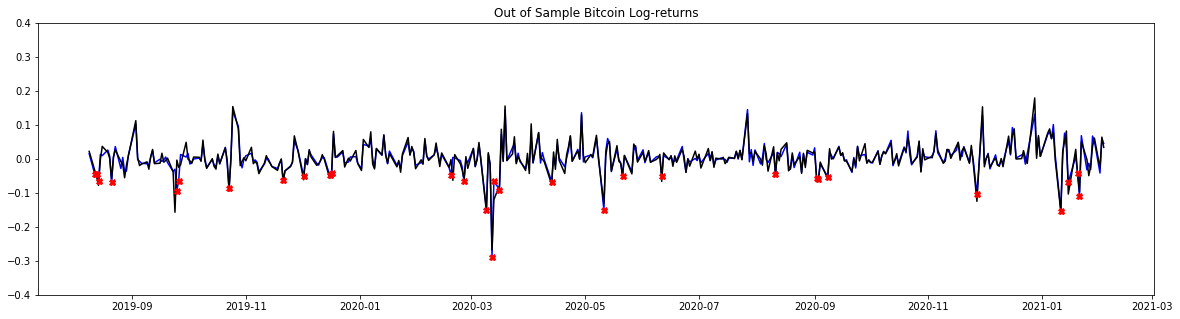

In [13]:
plt.figure(figsize=(20,5))
q=0.1
plt.title('Out of Sample Bitcoin Log-returns')
# print(np.sum(_id))
# _id = (rs<=np.quantile(rs,q)) & (rf<=np.quantile(rf,q)) 
_id = (rs<=np.quantile(rs,30/len(rs))) # 30 smallest rs

plt.plot(rs, 'b')
plt.plot(rf, 'black')
# _id = (rs<=np.quantile(rs,q)) & (rf<=np.quantile(rf,q)) 
plt.plot(rs[_id],'rX')
plt.ylim((-0.4,0.4))

# plt.plot(rf[_id],'bX')
plt.savefig('../latex/_pics/OOSBitcoin.png', transparent=True)
# _id = (rs>np.quantile(rs,1-q)) & (rf>np.quantile(rf,1-q)) 
# plt.plot(rs[_id],'rX')
# plt.plot(rf[_id],'bX')

In [336]:
# plt.figure(figsize=(20,5))
# plt.plot(rs, 'r')
# q = 0.1

# rs_U = rs.loc[rs<=np.quantile(rs,q)]
# plt.plot(np.array(rs_U.index),np.array(rs_U),'rx')

# rs_L = rs.loc[rs>np.quantile(rs,1-q)]
# plt.plot(np.array(rs_L.index),np.array(rs_L),'r+')

# rf_U = rf.loc[rf<=np.quantile(rf,q)]
# plt.plot(np.array(rf_U.index),np.array(rf_U),'bx')

# rf_L = rf.loc[rf>np.quantile(rf,1-q)]
# plt.plot(np.array(rf_L.index),np.array(rf_L),'b+')

# plt.plot(rf, 'b')

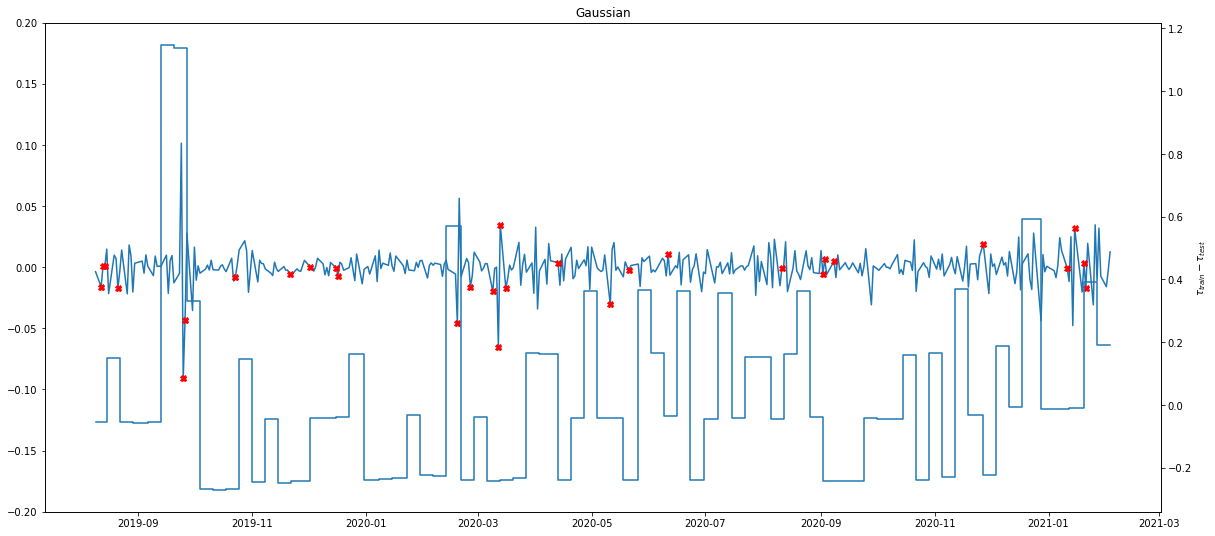

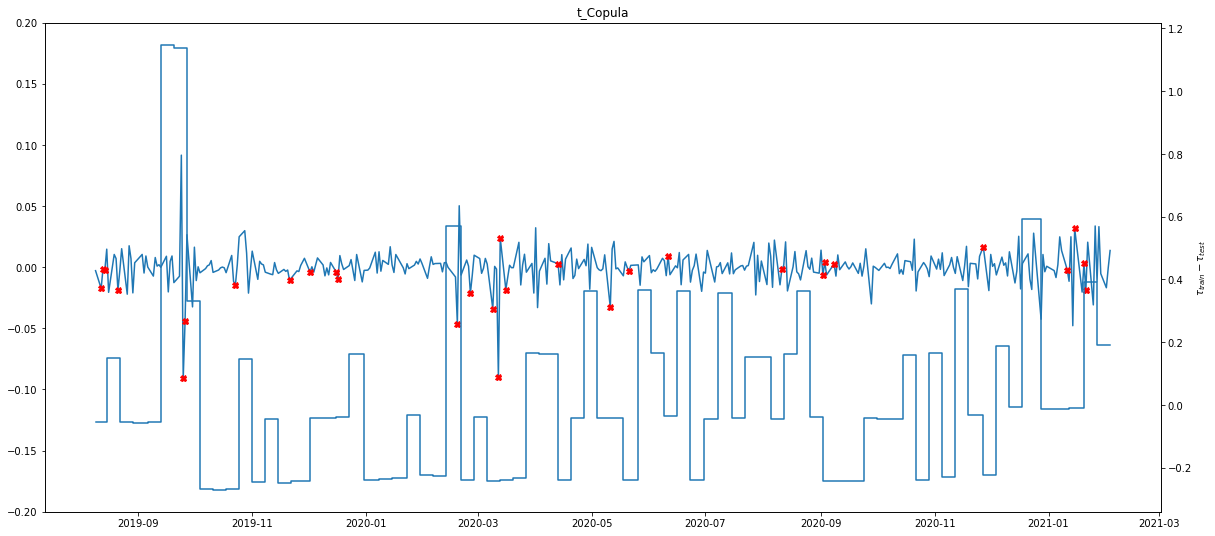

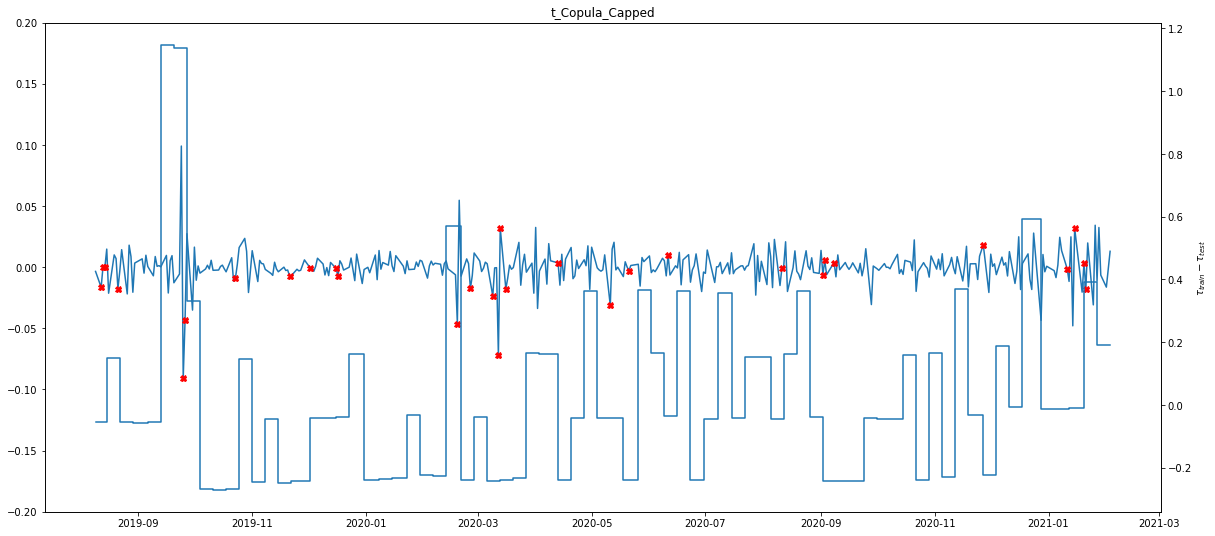

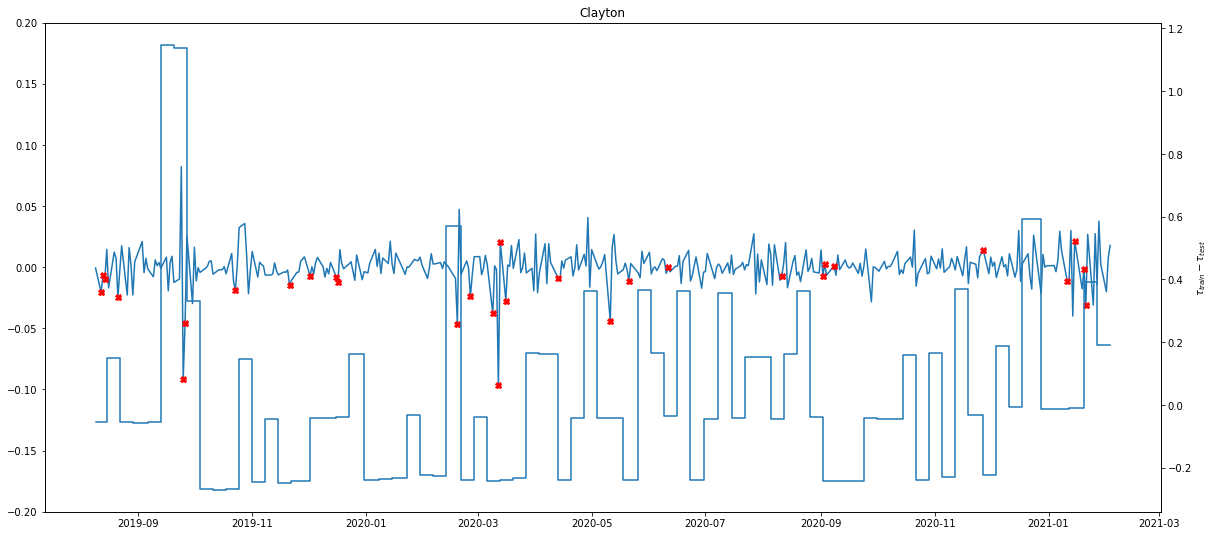

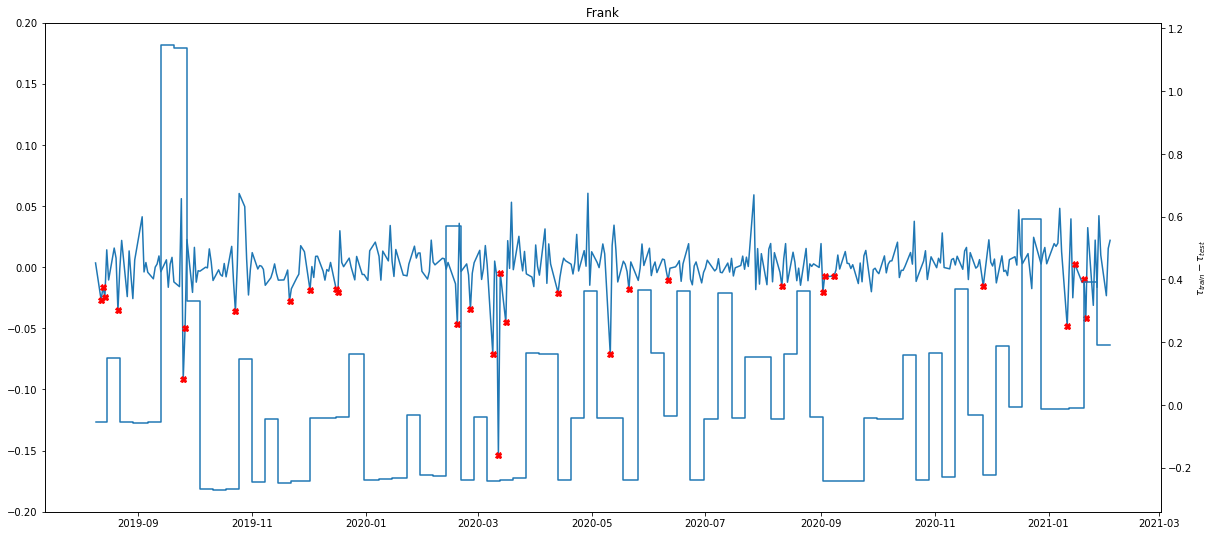

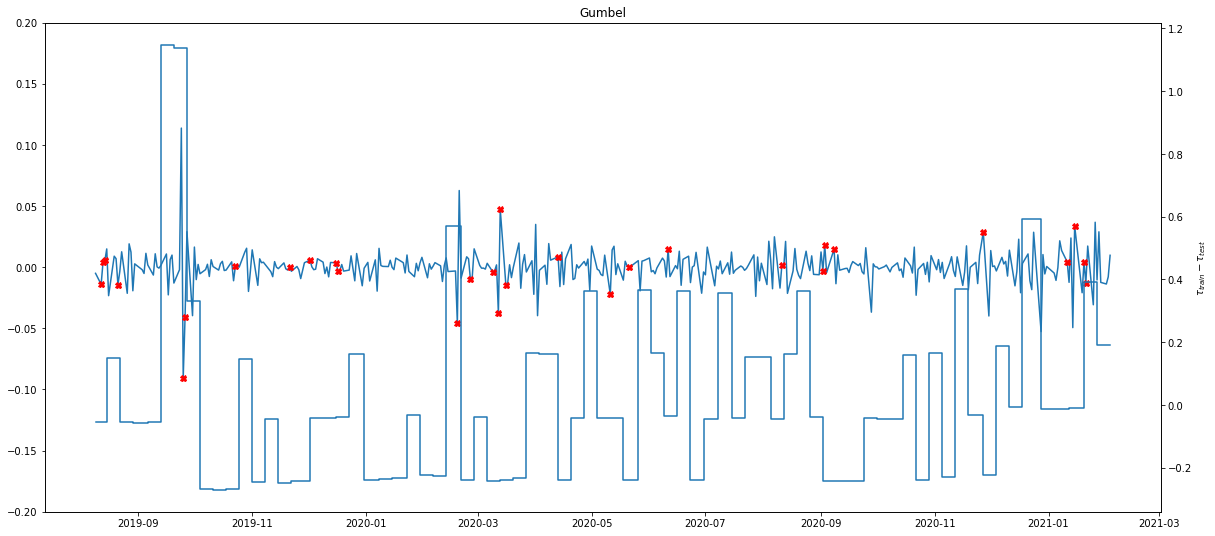

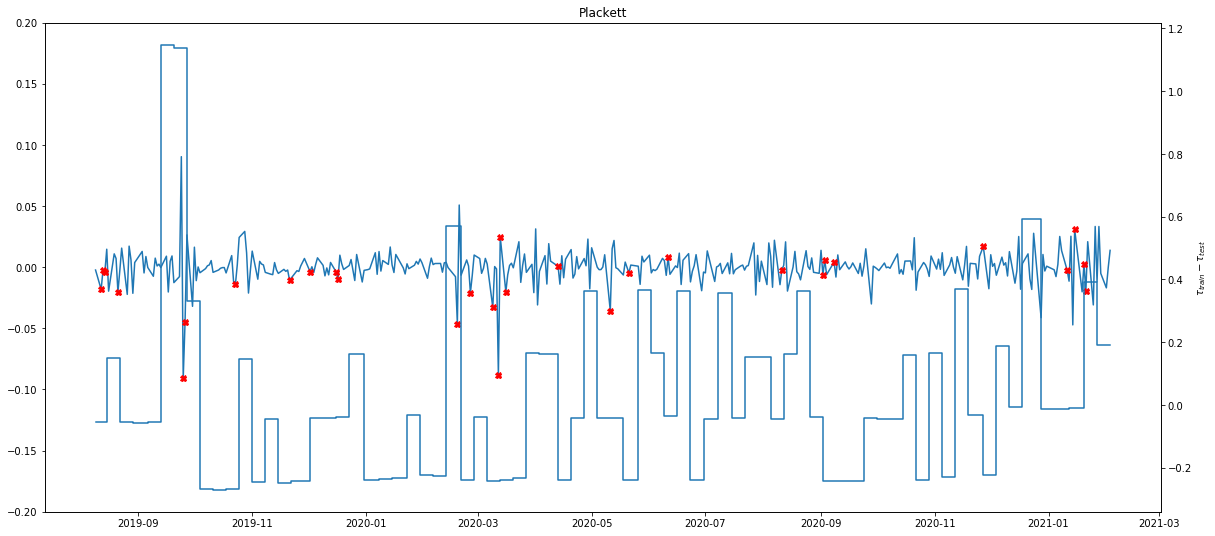

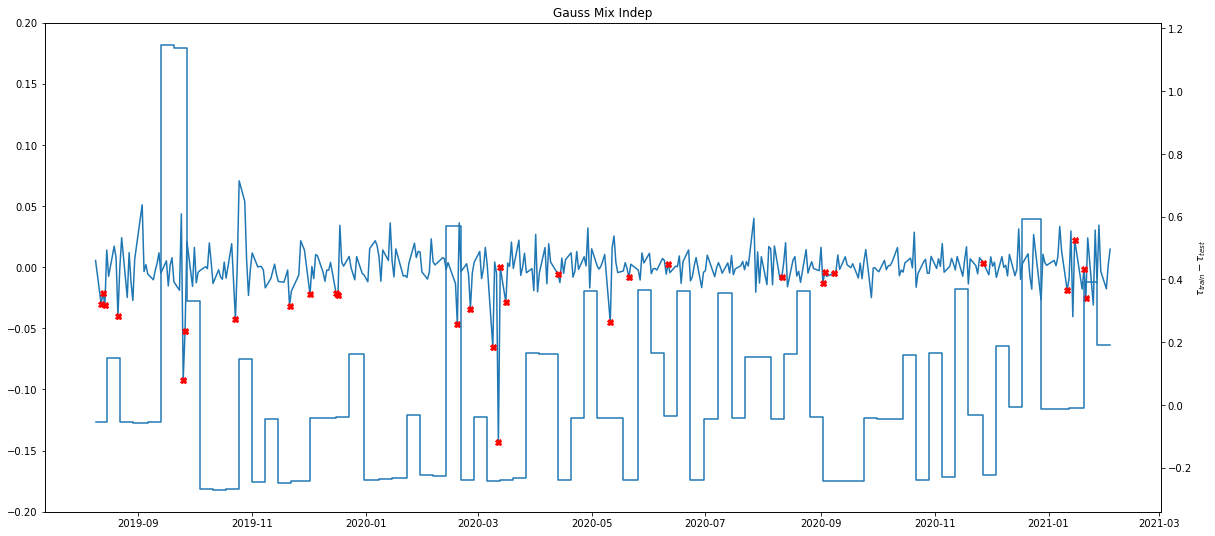

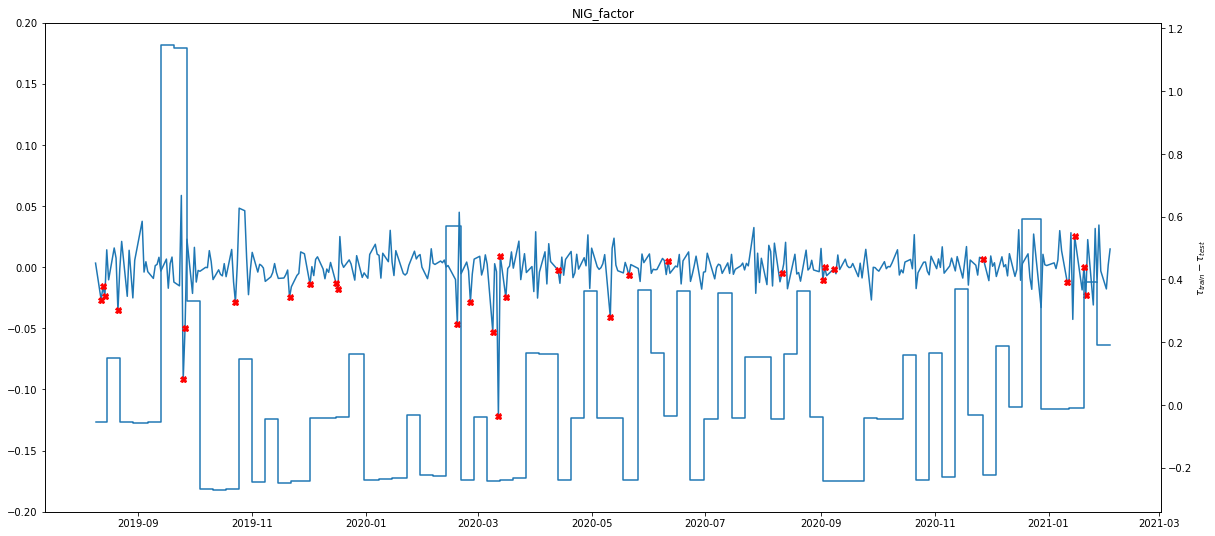

In [15]:
for i in range(len(Copula_names)):
    fig, ax1 = plt.subplots(figsize=(20,1*len(Copula_names)))
    ax2 = ax1.twinx()  
    C = Copula_names[i]
#     plt.figure(figsize=(20,5))
    ax1.set_title(Copula_names[i])
    ax1.plot(rh.loc[C,:])
    ax1.plot(rh.T.loc[_id, C], 'rX')
    ax1.set_ylim((-0.2,0.2))

    ax2.step(tau_arr.index, tau_arr)
    ax2.set_ylabel(r'$\tau_{train} - \tau_{test}$')

#     plt.plot(rh.loc[C,rs_L.index],'rx')
#     plt.plot(rh.loc[C,rs_U.index],'r+')
#     plt.plot(rh.loc[C,rf_L.index],'bx')
#     plt.plot(rh.loc[C,rf_U.index],'b+')
#     plt.ylim((-0.2,0.2))
# plt.hlines(np.quantile(rh.loc[Copula_names[0],:], q), xmin=rh.columns[0], xmax=rh.columns[-1])
# plt.hlines(np.quantile(rh.loc[Copula_names[0],:], 1-q), xmin=rh.columns[0], xmax=rh.columns[-1])

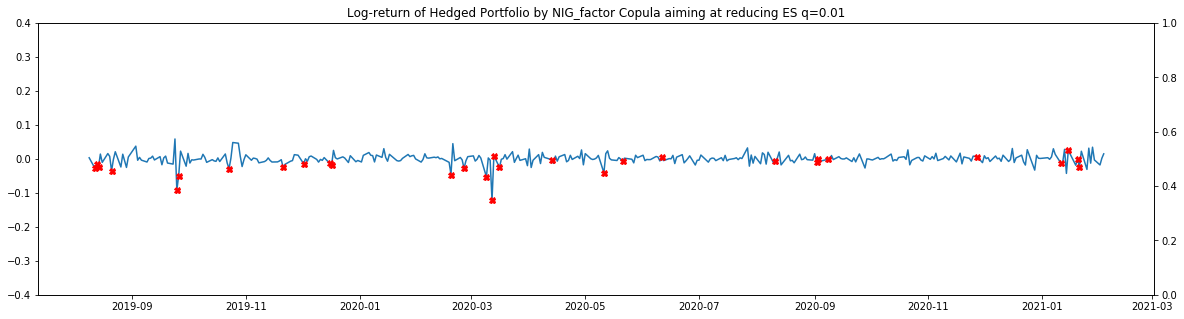

In [16]:
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()  
C = Copula_names[i]
#     plt.figure(figsize=(20,5))
ax1.set_title('Log-return of Hedged Portfolio by '+ Copula_names[i]+' Copula aiming at reducing '+rm)
ax1.plot(rh.loc[C,:])
ax1.plot(rh.T.loc[_id, C], 'rX')
ax1.set_ylim((-0.4,0.4))
plt.savefig('../latex/_pics/Gumbel_rh.png', transparent=True)
# _rh = rh.loc[C,:]
# S = pd.Series({'mean':np.mean(_rh), 
#  'std':np.std(_rh),
#  'skew':stats.skew(_rh),
#  'kurt':stats.kurtosis(_rh),
#  'max': np.max(_rh),
#  'UQ': np.quantile(_rh, 0.75),
#  'median': np.quantile(_rh, 0.5),
#  'LQ': np.quantile(_rh, 0.25), 
#  'min':np.min(_rh)})
# plt.figure(figsize=(5,5))
# sns.distplot(_rh)
# print(S)

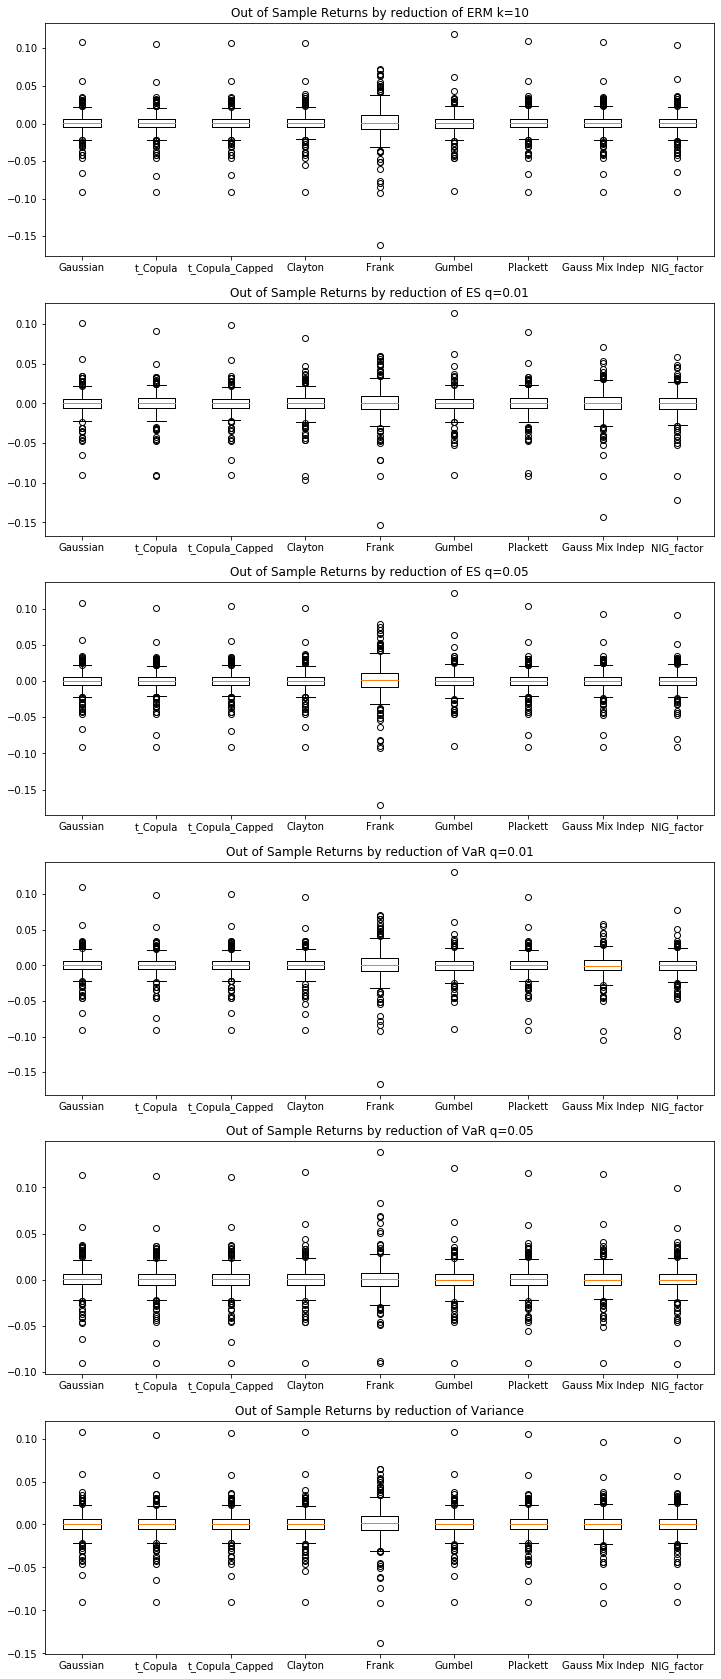

In [31]:
from plotly.subplots import make_subplots
fig, ax = plt.subplots(len(risk_measures), 1, figsize=(12,5*len(risk_measures)))
for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for file in ls:
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)

    rh = pd.concat(rh_arr, axis=1)
    rh = rh.sort_index(axis=1)
    rs = pd.concat(rs_arr)
    rs = rs.sort_index()

    rf = pd.concat(rf_arr)
    rf = rf.sort_index()

    rh = rh.apply(pd.to_numeric)
    ax[i].boxplot(rh)
    ax[i].set_xticklabels(Copula_names)
    ax[i].set_title("Out of Sample Returns by reduction of %s" %rm)
    M = np.mean(rh, axis=1)
    STD = np.std(rh, axis=1)

    MAX = np.max(rh, axis=1)
    MAX_date = rh.isin(MAX).idxmax(axis=1)

    UQ = rh.apply(lambda x: np.quantile(x, 0.75, interpolation='higher'), axis=1)
    UQ_date = rh.isin(UQ).idxmax(axis=1)

    LQ = rh.apply(lambda x: np.quantile(x, 0.25, interpolation='higher'), axis=1)
    LQ_date = rh.isin(LQ).idxmax(axis=1)

    MIN = np.min(rh, axis=1)
    MIN_date = rh.isin(MIN).idxmax(axis=1)

    rh_stats = pd.concat([M, STD, MAX, MAX_date, UQ, UQ_date, LQ, LQ_date, MIN, MIN_date], axis=1)
    rh_stats.columns = ['mean', 'std', 
                        'max', 'max on',
                        'UQ', 'UQ on', 
                        'LQ', 'LQ on',
                        'min', 'min on']
    rh_stats.to_html(result_path+'rh_stats_%s.html'%rm)



    for C in Copula_names:
        _rh = rh.loc[C,:]

        fig = make_subplots(
            rows=3, cols=2,
            column_widths=[10, 10],
            row_heights=[10, 10, 10],
            specs=[[{"type":"xy","colspan": 2}, None],
                   [{"type":"xy","colspan": 2}, None],
                   [{"type": "histogram2d"}, {"type":"table"}]],
            subplot_titles=("Rh Time Series","OHR", "Histogram", "Rh Statistics"))
        
        # Line plot with extreme data points
        df = pd.DataFrame(_rh).reset_index()
        fig.add_trace(go.Scatter(x=df.loc[:,'Date'], y=df.loc[:,C]), row=1,col=1)
        fig.add_trace(go.Scatter(x=rh.T.loc[_id, C].index, y=rh.T.loc[_id, C],
                            mode='markers'))
        fig.update_yaxes(range=[-0.2, 0.2], row=1, col=1)

        
        # Step plot of h
        dates = [pd.read_csv(data_path +'/test/'+file).iloc[-1,:].Date for file in ls]
        end_date = _rh.index[-1]
        h_4plot = pd.concat([OHR.loc[:, file].loc[:,rm] for file in ls],keys = dates, axis=1)
        h_4plot = h_4plot.sort_index(axis=1)
        h_4plot.loc[:,end_date] = h_4plot.iloc[:,-1]
        fig.add_trace(go.Scatter(x=pd.to_datetime(h_4plot.columns), y=h_4plot.loc[C,:], line= {"shape": 'hv'}),
                      row=2,col=1)
        fig.update_yaxes(range=[np.min(np.min(OHR))*.9, np.max(np.max(OHR))*1.1], row=2, col=1)

        # Table
        S = pd.Series({'mean':np.mean(_rh), 
         'std':np.std(_rh),
         'skew':stats.skew(_rh),
         'kurt':stats.kurtosis(_rh),
         'max': np.max(_rh),
         'UQ': np.quantile(_rh, 0.75),
         'median': np.quantile(_rh, 0.5),
         'LQ': np.quantile(_rh, 0.25), 
         'min':np.min(_rh)})
        df = pd.DataFrame(S)
        df = df.reset_index()
        df.columns = ['Statistics', 'Value']
        fig.add_trace(go.Table(
            header=dict(values=list(df.columns),
                        fill_color='paleturquoise',
                        align='left'),
            cells=dict(values=[df.iloc[:,0],df.iloc[:,1]],
                       fill_color='lavender',
                       align='left'))
        , row=3,col=2)

        uq = np.quantile(_rh, .75)
        lq = np.quantile(_rh, .25)
        bw = 1.06*min(np.std(_rh), (uq-lq)/1.34)*len(_rh)**(-1/5)

        distplfig = ff.create_distplot([np.array(_rh)],
                                       ['rh'], bin_size=bw, show_rug=False)

        fig.add_trace(go.Histogram(distplfig['data'][0],
                                   marker_color='red'
                                  ), row=3, col=1)

        fig.update_layout(height=1000, width=1200, title_text=C+' '+rm)

        fig.write_html(report_path+C+"_"+rm+".html")
        
plt.savefig(result_path+'Out of Sample Returns Boxplot.png', transparent=True)


In [30]:
pd.to_datetime(h_4plot.columns)

DatetimeIndex(['2019-08-09', '2019-08-16', '2019-08-23', '2019-08-30',
               '2019-09-09', '2019-09-16', '2019-09-23', '2019-09-30',
               '2019-10-07', '2019-10-14', '2019-10-21', '2019-10-28',
               '2019-11-04', '2019-11-11', '2019-11-18', '2019-11-25',
               '2019-12-03', '2019-12-10', '2019-12-17', '2019-12-24',
               '2020-01-02', '2020-01-09', '2020-01-16', '2020-01-24',
               '2020-01-31', '2020-02-07', '2020-02-14', '2020-02-24',
               '2020-03-02', '2020-03-09', '2020-03-16', '2020-03-23',
               '2020-03-30', '2020-04-06', '2020-04-14', '2020-04-21',
               '2020-04-28', '2020-05-05', '2020-05-12', '2020-05-19',
               '2020-05-27', '2020-06-03', '2020-06-10', '2020-06-17',
               '2020-06-24', '2020-07-01', '2020-07-09', '2020-07-16',
               '2020-07-23', '2020-07-30', '2020-08-06', '2020-08-13',
               '2020-08-20', '2020-08-27', '2020-09-03', '2020-09-11',
      

In [29]:
df = pd.DataFrame(_rh).reset_index()
df.Date

0     2019-08-09
1     2019-08-12
2     2019-08-13
3     2019-08-14
4     2019-08-15
5     2019-08-16
6     2019-08-19
7     2019-08-20
8     2019-08-21
9     2019-08-22
10    2019-08-23
11    2019-08-26
12    2019-08-27
13    2019-08-28
14    2019-08-29
15    2019-08-30
16    2019-09-03
17    2019-09-04
18    2019-09-05
19    2019-09-06
20    2019-09-09
21    2019-09-10
22    2019-09-11
23    2019-09-12
24    2019-09-13
25    2019-09-16
26    2019-09-17
27    2019-09-18
28    2019-09-19
29    2019-09-20
         ...    
345   2020-12-21
346   2020-12-22
347   2020-12-23
348   2020-12-24
349   2020-12-28
350   2020-12-29
351   2020-12-30
352   2020-12-31
353   2021-01-04
354   2021-01-05
355   2021-01-06
356   2021-01-07
357   2021-01-08
358   2021-01-11
359   2021-01-12
360   2021-01-13
361   2021-01-14
362   2021-01-15
363   2021-01-19
364   2021-01-20
365   2021-01-21
366   2021-01-22
367   2021-01-25
368   2021-01-26
369   2021-01-27
370   2021-01-28
371   2021-01-29
372   2021-02-

In [20]:
M = np.mean(rh, axis=1)
STD = np.std(rh, axis=1)

MAX = np.max(rh, axis=1)
MAX_date = rh.isin(MAX).idxmax(axis=1)

UQ = rh.apply(lambda x: np.quantile(x, 0.75, interpolation='higher'), axis=1)
UQ_date = rh.isin(UQ).idxmax(axis=1)

LQ = rh.apply(lambda x: np.quantile(x, 0.25, interpolation='higher'), axis=1)
LQ_date = rh.isin(LQ).idxmax(axis=1)

MIN = np.min(rh, axis=1)
MIN_date = rh.isin(MIN).idxmax(axis=1)

rh_stats = pd.concat([M, STD, MAX, MAX_date, UQ, UQ_date, LQ, LQ_date, MIN, MIN_date], axis=1)
rh_stats.columns = ['mean', 'std', 
                    'max', 'max on',
                    'UQ', 'UQ on', 
                    'LQ', 'LQ on',
                    'min', 'min on']
rh_stats.to_html(result_path+'rh_stats_%s.html'%rm)

In [21]:
# import json
# with open('../src/configs/config_coingecko_future_v1_MM.json','r') as file:
#     config = json.load(file)
# config
# data_name = config['data_name']
# calibration_method  = config['calibration_method']
# OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')
# if not os.path.exists("../results/" + data_name + "/MLE/reports"):
# 	print("Create new folder for results")
# 	os.mkdir("../results/" + data_name + "/MLE/reports")
# 	os.mkdir("../results/" + data_name + "/MM/reports")
    
# if calibration_method == "MLE":
#     report_path = "../results/" + data_name + "/MLE/reports/"
#     result_path = "../results/" + data_name + "/MLE/"
# elif calibration_method == "MM":
#     report_path = "../results/" + data_name + "/MM/reports/"
#     result_path = "../results/" + data_name + "/MM/"


In [22]:
h_diff_arr = []
for rm in risk_measures:
    h = OHR.droplevel(0,1).loc[:, rm]
    h_diff = np.sum(np.abs(h.iloc[:,:-1] - h.iloc[:,1:]), axis=1)
    h_diff_arr.append(h_diff)

In [23]:
h_diff_df = pd.concat(h_diff_arr, axis=1)
h_diff_df.columns = risk_measures

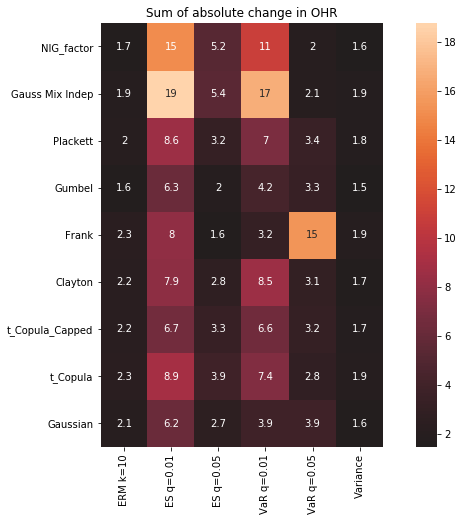

In [25]:
plt.figure(figsize=(9*1.3,6*1.3))
# sns.cubehelix_palette(as_cmap=True, reverse=True)
sns.heatmap(h_diff_df,square=True, center=True, annot=True)
plt.ylim(0,len(h_diff_df))
plt.title('Sum of absolute change in OHR')
plt.savefig(result_path+'Sum of absolute change in OHR.png', transparent=True)

In [ ]:
h_diff_df.iloc[[0,1,2,3,5,6,7,8],:].style.highlight_min(color = 'lightgreen', axis = 0)

In [32]:
def hedging_effectiveness2(rm, rh, rs):
	if rm.startswith('Variance'):
		return 1 - Variance(rh) / Variance(rs)

	elif rm.startswith('ERM'):
		k = float(rm[rm.find('=') + 1:])
		return 1 - ERM_estimate_trapezoidal(k, rh) / ERM_estimate_trapezoidal(k, rs)

	elif rm.startswith('ES'):
		q = float(rm[rm.find('=') + 1:])
		return 1 - ES(q, rh) / ES(q, rs)

	elif rm.startswith('VaR'):
		q = float(rm[rm.find('=') + 1:])
		return 1 - VaR(q, rh) / VaR(q, rs)

In [33]:
for C in Copula_names:
    print(hedging_effectiveness2(rm=rm, rh=rh.loc[C,:], rs=rs))

0.8806446456835866
0.8804447880302881
0.8807065506960728
0.8810903546276784
0.7914023701702504
0.8801886951378947
0.8796485994499046
0.8787394276174836
0.8786146587840766


In [54]:
HE2 = []
rm = 'ES q=0.01'
C='NIG_factor'

for _ in range(1000):
    _id = np.random.choice(range(len(rh.loc[C,:])),len(rh.loc[C,:]), True)
    HE2.append(hedging_effectiveness2(rm=rm,
                                      rh=rh.loc[C,:].iloc[_id],
                                      rs=rs.iloc[_id]))
    


In [55]:

hedging_effectiveness2(rm=rm,
                                      rh=rh.loc[C,:],
                                      rs=rs)

0.6608820005412085

In [ ]:
plt.figure(figsize=(10,5))
plt.boxplot(rh.loc[:,_id])
plt.plot()

In [61]:
def rename_rm(rm):
    rm = rm.replace('q=','')
    rm = rm.replace('0.01', '99%')
    rm = rm.replace('0.05', '95%')
    return rm

rename_rm('ES q=0.01')

'ES 99%'

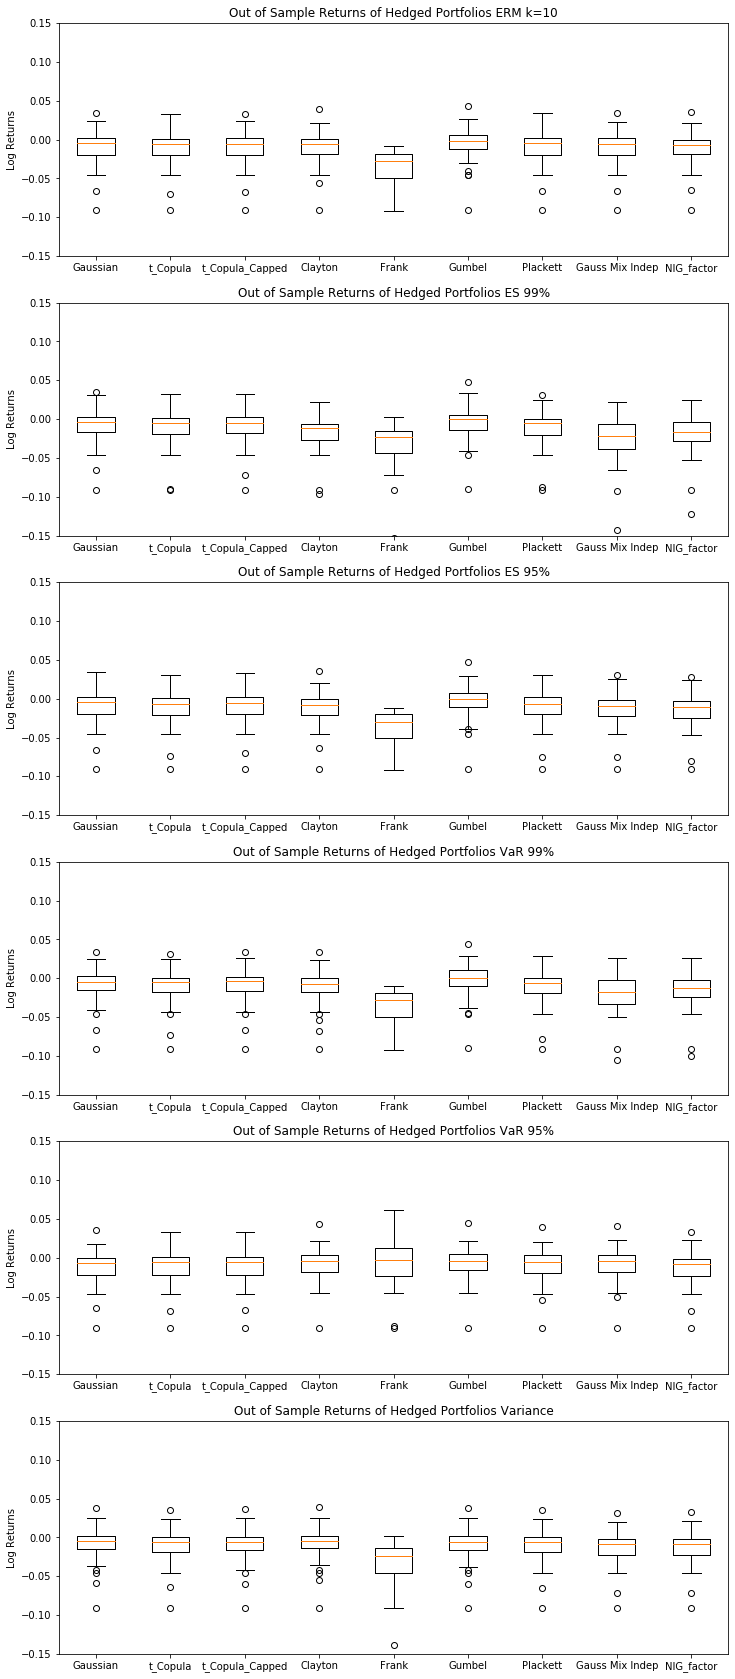

In [67]:
_id = (rs<=np.quantile(rs,30/len(rs))) # 30 smallest rs
fig, ax = plt.subplots(len(risk_measures), 1, figsize=(12,5*len(risk_measures)))

for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for file in ls:
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)

    rh = pd.concat(rh_arr, axis=1)
    rh = rh.sort_index(axis=1)
    rs = pd.concat(rs_arr)
    rs = rs.sort_index()

    rf = pd.concat(rf_arr)
    rf = rf.sort_index()

    rh = rh.apply(pd.to_numeric)
    ax[i].set_title('Out of Sample Returns of Hedged Portfolios ' + rename_rm(rm))
    ax[i].set_ylim((-0.15, 0.15))
    ax[i].set_ylabel('Log Returns')
    ax[i].boxplot(rh.loc[:,_id])
    ax[i].set_xticklabels(Copula_names)

#     plt.plot()

In [82]:
C = Gaussian_Mix_Independent({'rho':0.9, 'p':0.9}, stats.norm, stats.norm)
C.mm_calibrate(u,v, q_arr=[0.01,0.05,0.90,0.95])
q_arr = np.linspace(0.01,.99,50)
L_C1 = [C._lambda(q) for q in q_arr]

C.canonical_calibrate(u,v)
L_C2 = [C._lambda(q) for q in q_arr]


Optimization terminated successfully.
         Current function value: 0.063545
         Iterations: 168
         Function evaluations: 315
Optimization terminated successfully.
         Current function value: -1.029223
         Iterations: 70
         Function evaluations: 144


In [91]:
C = Gaussian_Mix_Independent({'rho':0.98, 'p':0.9}, stats.norm, stats.norm)
L_C3 = [C._lambda(q) for q in q_arr]


In [77]:
q_arr = np.linspace(0.01,.99,50)
L_arr = []

for _ in range(2000):
    _id = np.random.choice(range(len(u)),len(u), True)
    _u = u[_id]
    _v = v[_id]
    L = np.array([empirical_lambda(_u,_v,q) for q in q_arr])
    L_arr.append(L)
    
L_arr = np.array(L_arr)

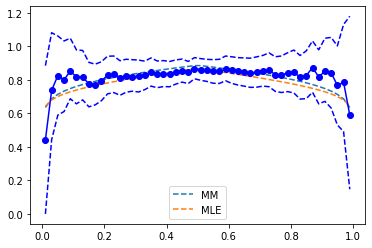

In [93]:
plt.plot(q_arr, L_C1, '--', label="MM")
plt.plot(q_arr, L_C2, '--', label="MLE")
# plt.plot(q_arr, L_C3, '--', label="?")

plt.plot(q_arr, np.quantile(np.array(L_arr), 0.5, axis=0), 'b-o')
plt.plot(q_arr, np.quantile(np.array(L_arr), 0.05, axis=0), 'b--')
plt.plot(q_arr, np.quantile(np.array(L_arr), 0.95, axis=0), 'b--')
plt.legend()

In [97]:
_id = (rs<=np.quantile(rs,30/len(rs))) # 30 smallest rs
# fig, ax = plt.subplots(len(risk_measures), 1, figsize=(12,5*len(risk_measures)))
rh_df = []
for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for file in ls:
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)

    rh = pd.concat(rh_arr, axis=1)
    rh = rh.sort_index(axis=1)
    rs = pd.concat(rs_arr)
    rs = rs.sort_index()

    rf = pd.concat(rf_arr)
    rf = rf.sort_index()
    rh = rh.apply(pd.to_numeric)
    rh_df.append(rh)

In [105]:

HE_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        HE_np[i,j]=hedging_effectiveness2(rm, rh_df[i].loc[C,:], rs)

In [114]:
HE_overall = pd.DataFrame(HE_np).T
HE_overall.columns = [rename_rm(rm) for rm in risk_measures]
HE_overall.index = Copula_names
HE_overall.style.highlight_max(color = 'lightgreen', axis = 0)

,ERM k=10,ES 99%,ES 95%,VaR 99%,VaR 95%,Variance
Gaussian,0.638017,0.66327,0.648327,0.639075,0.620206,0.880645
t_Copula,0.635983,0.629292,0.641339,0.635835,0.615522,0.880445
t_Copula_Capped,0.636865,0.654052,0.645123,0.633654,0.618269,0.880707
Clayton,0.64646,0.622775,0.651564,0.632297,0.622687,0.88109
Frank,0.470488,0.477708,0.426917,0.389306,0.558526,0.791402
Gumbel,0.637496,0.67855,0.648528,0.622935,0.639915,0.880189
Plackett,0.637564,0.632936,0.640505,0.642434,0.618027,0.879649
Gauss Mix Indep,0.63866,0.525042,0.642502,0.629769,0.623563,0.878739
NIG_factor,0.642813,0.57395,0.636836,0.632172,0.622884,0.878615


In [146]:
Variance_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        Variance_np[i,j]=Variance(rh_df[i].loc[C,:])**0.5
        
Variance_overall = pd.DataFrame(Variance_np).T
Variance_overall.columns = [rename_rm(rm) for rm in risk_measures]
Variance_overall.index = Copula_names
Variance_overall.style.highlight_min(color = 'lightgreen', axis = 1)

,ERM k=10,ES 99%,ES 95%,VaR 99%,VaR 95%,Variance
Gaussian,0.0143865,0.0143799,0.0143605,0.0145301,0.0146703,0.0142939
t_Copula,0.0143782,0.0146265,0.0143429,0.0143845,0.0146271,0.0143059
t_Copula_Capped,0.0143748,0.0144178,0.0143324,0.0144297,0.0146426,0.0142902
Clayton,0.014306,0.01487,0.0143324,0.0145322,0.014493,0.0142672
Frank,0.0214951,0.0189818,0.0227356,0.0214763,0.0181418,0.0188966
Gumbel,0.0146184,0.0149711,0.0148783,0.0154382,0.0146217,0.0143212
Plackett,0.0144436,0.0145601,0.0144239,0.0144231,0.0145956,0.0143534
Gauss Mix Indep,0.0144044,0.017404,0.0143415,0.0156707,0.0144526,0.0144075
NIG_factor,0.0143621,0.0158407,0.0144842,0.0150428,0.0144744,0.0144149


In [147]:
ERM_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        ERM_np[i,j]=ERM_estimate_trapezoidal(10, rh_df[i].loc[C,:])
        
ERM_overall = pd.DataFrame(ERM_np).T
ERM_overall.columns = [rename_rm(rm) for rm in risk_measures]
ERM_overall.index = Copula_names
ERM_overall.style.highlight_min(color = 'lightgreen', axis = 1)

,ERM k=10,ES 99%,ES 95%,VaR 99%,VaR 95%,Variance
Gaussian,0.0199849,0.0208021,0.0200605,0.0202303,0.019983,0.0197571
t_Copula,0.0200972,0.0216977,0.0203809,0.0209656,0.0200707,0.0198896
t_Copula_Capped,0.0200485,0.0210182,0.0202019,0.0205537,0.020059,0.0197921
Clayton,0.0195187,0.0213405,0.0197893,0.0210445,0.0193894,0.0196751
Frank,0.029234,0.0262399,0.0307696,0.0291566,0.0230849,0.0259281
Gumbel,0.0200136,0.0214113,0.020511,0.021643,0.019557,0.019757
Plackett,0.0200099,0.0215315,0.0203631,0.0208698,0.0197551,0.0199093
Gauss Mix Indep,0.0199494,0.0253896,0.0204539,0.0232826,0.0196672,0.0200061
NIG_factor,0.0197201,0.0234246,0.020706,0.0220385,0.0199503,0.0199988


In [152]:
VaR_99_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        VaR_99_np[i,j]=VaR(.01, rh_df[i].loc[C,:])
        
VaR_99_overall = pd.DataFrame(VaR_99_np).T
VaR_99_overall.columns = [rename_rm(rm) for rm in risk_measures]
VaR_99_overall.index = Copula_names
VaR_99_overall.style.highlight_min(color = 'lightgreen', axis = 1)

,ERM k=10,ES 99%,ES 95%,VaR 99%,VaR 95%,Variance
Gaussian,0.0413273,0.044416,0.0419425,0.0433995,0.0422751,0.041981
t_Copula,0.0414499,0.0448299,0.042806,0.043789,0.0416928,0.0419689
t_Copula_Capped,0.0414983,0.0441695,0.0424109,0.0440513,0.0420184,0.0420559
Clayton,0.0400222,0.0445233,0.0428784,0.0442145,0.0409132,0.0419427
Frank,0.0766444,0.0553866,0.0812728,0.0734329,0.0461774,0.0610562
Gumbel,0.0420789,0.0421391,0.0421869,0.0453402,0.0405231,0.0419368
Plackett,0.0410125,0.0449708,0.0423703,0.0429955,0.0415742,0.0417313
Gauss Mix Indep,0.0409982,0.0480171,0.0432495,0.0445185,0.0407491,0.0433855
NIG_factor,0.0404568,0.0472013,0.0439246,0.0442295,0.0432404,0.0431383


In [149]:
VaR_95_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        VaR_95_np[i,j]=VaR(.05, rh_df[i].loc[C,:])
        
VaR_95_overall = pd.DataFrame(VaR_95_np).T
VaR_95_overall.columns = [rename_rm(rm) for rm in risk_measures]
VaR_95_overall.index = Copula_names
VaR_95_overall.style.highlight_min(color = 'lightgreen', axis = 1)

,ERM k=10,ES 99%,ES 95%,VaR 99%,VaR 95%,Variance
Gaussian,0.0203851,0.0203151,0.0201426,0.0204121,0.0201215,0.0195788
t_Copula,0.0205466,0.0204283,0.0206613,0.0206106,0.0203697,0.0198199
t_Copula_Capped,0.0205252,0.0205439,0.0205025,0.0204861,0.0202242,0.0196556
Clayton,0.0197018,0.0210424,0.0201429,0.0206399,0.0199901,0.0197005
Frank,0.0263721,0.0235293,0.0271054,0.0262123,0.0233893,0.0235943
Gumbel,0.0197806,0.0213109,0.020716,0.020421,0.0190773,0.0195413
Plackett,0.0204593,0.0202566,0.0205893,0.0201002,0.0202369,0.0200467
Gauss Mix Indep,0.0204823,0.0247533,0.0203041,0.0241576,0.0199437,0.0207228
NIG_factor,0.0199228,0.0237843,0.0210089,0.0221724,0.0199796,0.0206696


In [150]:
ES_99_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        ES_99_np[i,j]=ES(.01, rh_df[i].loc[C,:])
        
ES_99_overall = pd.DataFrame(ES_99_np).T
ES_99_overall.columns = [rename_rm(rm) for rm in risk_measures]
ES_99_overall.index = Copula_names
ES_99_overall.style.highlight_min(color = 'lightgreen', axis = 1)

,ERM k=10,ES 99%,ES 95%,VaR 99%,VaR 95%,Variance
Gaussian,0.0610838,0.0624054,0.0612008,0.0621479,0.061712,0.05931
t_Copula,0.0621479,0.0687024,0.063339,0.0639643,0.0620668,0.0607354
t_Copula_Capped,0.061623,0.0641136,0.0621981,0.0624659,0.0620725,0.0596757
Clayton,0.0584948,0.0699103,0.0608117,0.0645948,0.0559617,0.0583181
Frank,0.104185,0.096795,0.108713,0.10507,0.0684568,0.0913207
Gumbel,0.0565126,0.0595735,0.0560354,0.0581617,0.0554919,0.0595253
Plackett,0.0611673,0.068027,0.0634257,0.0645633,0.0584907,0.0610171
Gauss Mix Indep,0.0611574,0.0880228,0.0638996,0.0733164,0.0570073,0.0630812
NIG_factor,0.0608782,0.0789587,0.0652697,0.0709189,0.0620971,0.0628479


In [151]:
ES_95_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        ES_95_np[i,j]=ES(.05, rh_df[i].loc[C,:])
        
ES_95_overall = pd.DataFrame(ES_95_np).T
ES_95_overall.columns = [rename_rm(rm) for rm in risk_measures]
ES_95_overall.index = Copula_names
ES_95_overall.style.highlight_min(color = 'lightgreen', axis = 1)

,ERM k=10,ES 99%,ES 95%,VaR 99%,VaR 95%,Variance
Gaussian,0.0344875,0.0352366,0.0345477,0.0351233,0.0348379,0.0342483
t_Copula,0.0347769,0.0371002,0.0352342,0.0356335,0.0350547,0.0344944
t_Copula_Capped,0.0346469,0.0356794,0.0348625,0.0352825,0.0349375,0.0343224
Clayton,0.0337136,0.0372816,0.0342297,0.0360893,0.0334446,0.0340457
Frank,0.0536606,0.047849,0.0562986,0.0534094,0.0376375,0.0469531
Gumbel,0.0340284,0.0359652,0.034528,0.0363526,0.033568,0.0342933
Plackett,0.0345919,0.0368308,0.0353162,0.0357519,0.0341859,0.0345578
Gauss Mix Indep,0.0344389,0.0451599,0.0351199,0.0400273,0.0337562,0.0344784
NIG_factor,0.0338817,0.0410015,0.0356766,0.0379753,0.0346564,0.0344531


In [153]:
# print("\\begin{table}")
# print(ERM_overall.to_latex(index=True))
# print("\\caption{Exponential Risk Measure $k=10$}")
# print("\\end{table}")

# print("\\begin{table}")
# print(ES_99_overall.to_latex(index=True))
# print("\\caption{ES 99\%}")
# print("\\end{table}")

# print("\\begin{table}")
# print(ES_95_overall.to_latex(index=True))
# print("\\caption{ES 95\%}")
# print("\\end{table}")

print("\\begin{table}")
print(VaR_99_overall.to_latex(index=True))
print("\\caption{VaR 99\%}")
print("\\end{table}")

# print("\\begin{table}")
# print(VaR_95_overall.to_latex(index=True))
# print("\\caption{VaR 95\%}")
# print("\\end{table}")

# print("\\begin{table}")
# print(Variance_overall.to_latex(index=True))
# print("\\caption{Variance}")
# print("\\end{table}")


\begin{table}
\begin{tabular}{lrrrrrr}
\toprule
{} &  ERM k=10 &    ES 99\% &    ES 95\% &   VaR 99\% &   VaR 95\% &  Variance \\
\midrule
Gaussian        &  0.041327 &  0.044416 &  0.041943 &  0.043399 &  0.042275 &  0.041981 \\
t\_Copula        &  0.041450 &  0.044830 &  0.042806 &  0.043789 &  0.041693 &  0.041969 \\
t\_Copula\_Capped &  0.041498 &  0.044169 &  0.042411 &  0.044051 &  0.042018 &  0.042056 \\
Clayton         &  0.040022 &  0.044523 &  0.042878 &  0.044215 &  0.040913 &  0.041943 \\
Frank           &  0.076644 &  0.055387 &  0.081273 &  0.073433 &  0.046177 &  0.061056 \\
Gumbel          &  0.042079 &  0.042139 &  0.042187 &  0.045340 &  0.040523 &  0.041937 \\
Plackett        &  0.041013 &  0.044971 &  0.042370 &  0.042995 &  0.041574 &  0.041731 \\
Gauss Mix Indep &  0.040998 &  0.048017 &  0.043249 &  0.044518 &  0.040749 &  0.043386 \\
NIG\_factor      &  0.040457 &  0.047201 &  0.043925 &  0.044230 &  0.043240 &  0.043138 \\
\bottomrule
\end{tabular}

\caption{Va

In [168]:
h_4plot_arr = []
for rm in risk_measures:
    dates = [pd.read_csv(data_path +'/test/'+file).iloc[-1,:].Date for file in ls]
    end_date = _rh.index[-1]
    h_4plot = pd.concat([OHR.loc[:, file].loc[:,rm] for file in ls],keys = dates, axis=1)
    h_4plot = h_4plot.sort_index(axis=1)
    h_4plot.loc[:,end_date] = h_4plot.iloc[:,-1]
    h_4plot.columns = pd.to_datetime(h_4plot.columns)
    h_4plot_arr.append(h_4plot)

In [178]:
risk_measures

Index(['ERM k=10', 'ES q=0.01', 'ES q=0.05', 'VaR q=0.01', 'VaR q=0.05',
       'Variance'],
      dtype='object')

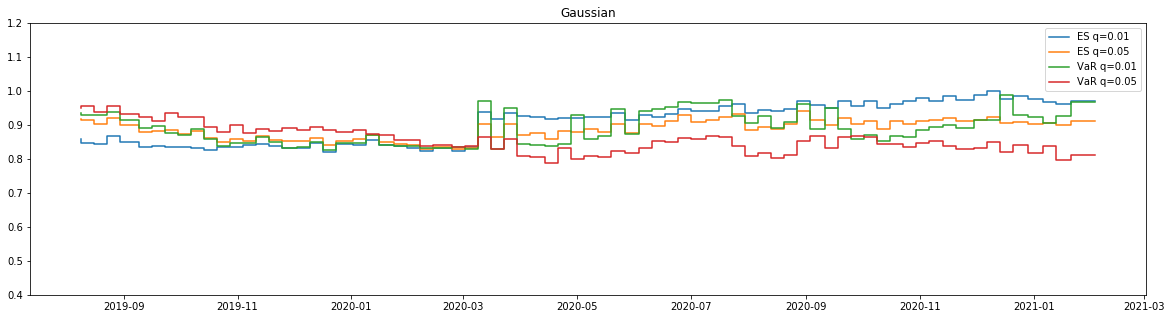

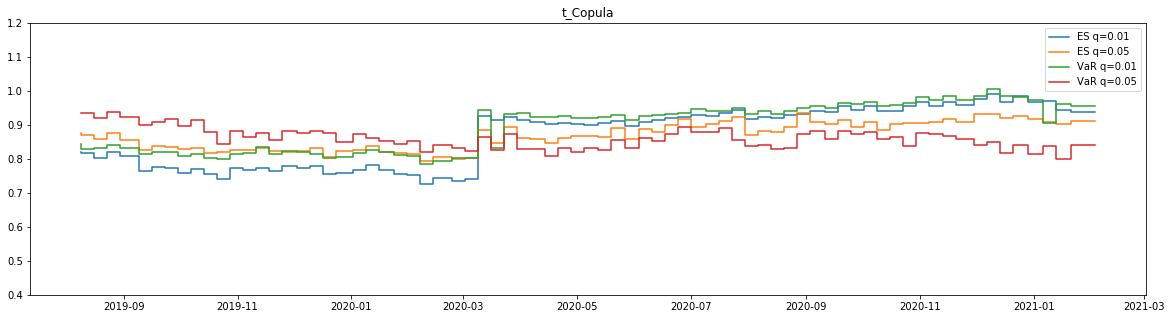

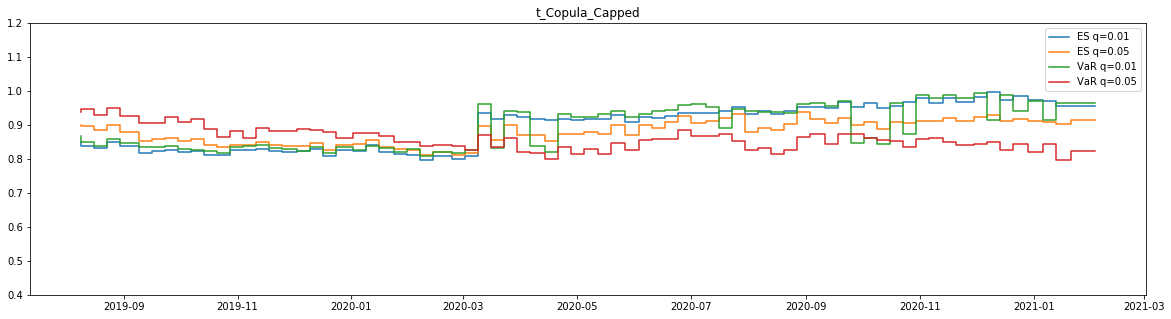

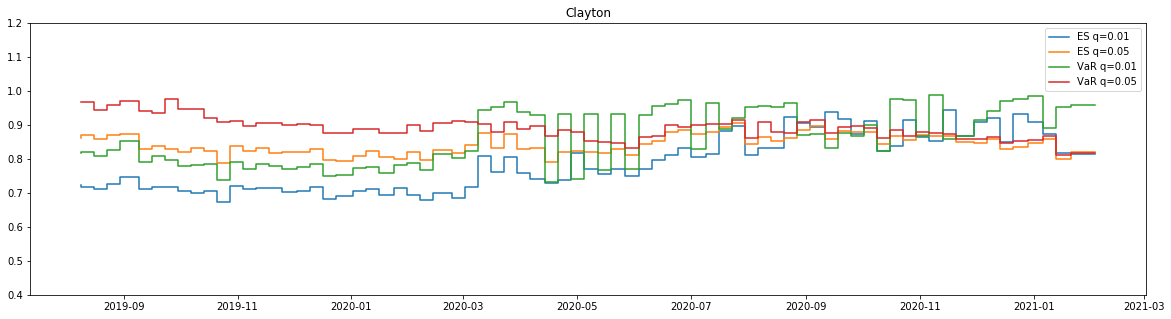

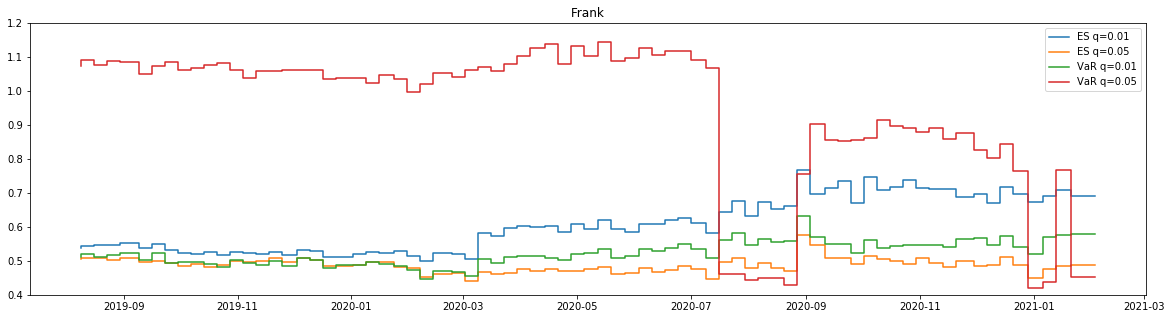

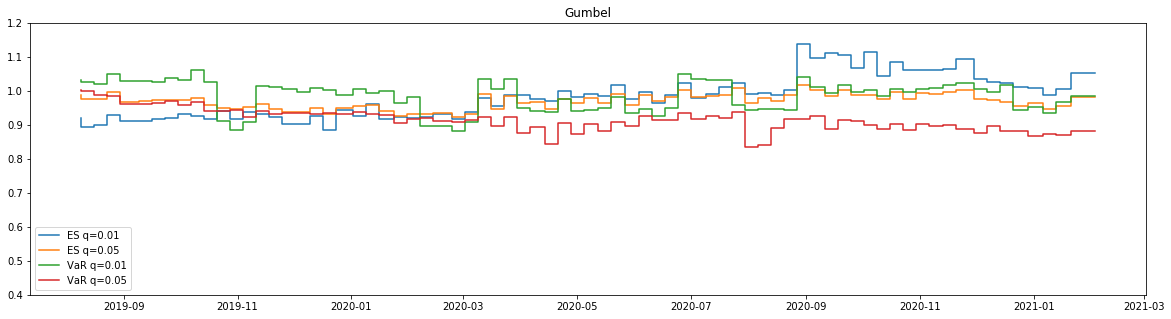

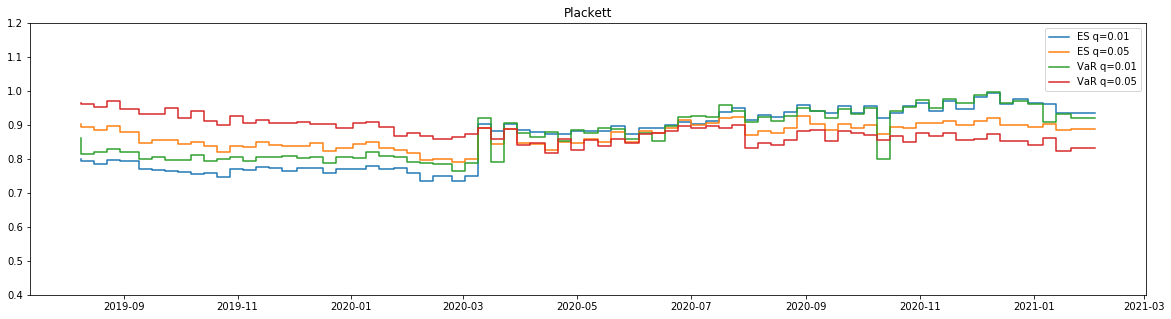

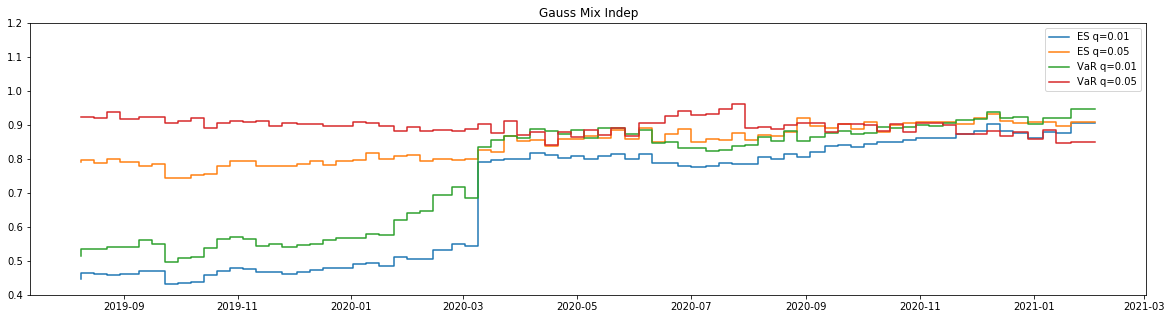

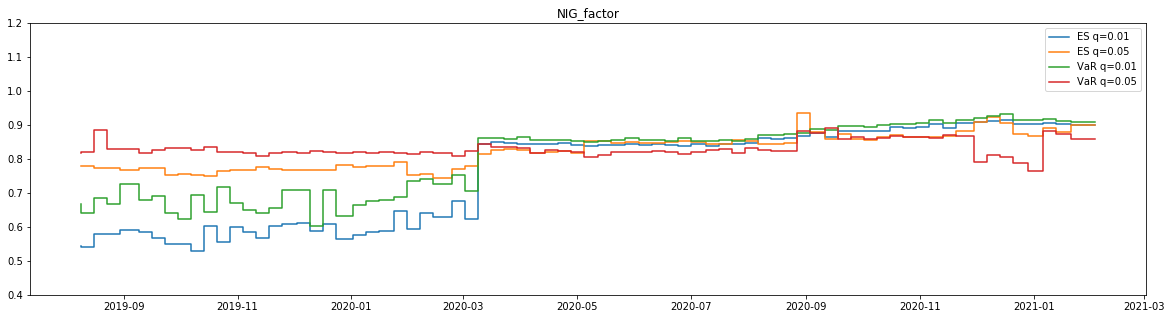

In [206]:
for C in Copula_names:
    plt.figure(figsize=(20,5))
    plt.ylim((0.4,1.2))
    plt.title(C)
#     for i in range(len(h_4plot_arr)):
    for i in [1,2,3,4]:
        plt.step(x=h_4plot_arr[i].loc[C,:].index, y=h_4plot_arr[i].loc[C,:], label=risk_measures[i])
    plt.legend()

The overall strategy:
1. observe copula across risk reduction objective
- Kick out Frank because of HEs and PnL
- Other copula are producing similar results of HEs and PnL under the same risk reduction objective
-- PnL, conditional PnL (conditioned on extremes of RS)
- Gumbel Copula ex-ante hedge extreme by keeping a high h*
- None of the copula can escape from dependence break 

2. observe risk reduction objectives across copula
- 99% VaR and ES are too sensitive 
- ERM is a smoothed version ES --> give consistent results

1. h is high to begin with, Gumbel is consistently high, pick some of the extreme better then the others
2. consistently high h 

normal time, no extreme, h<<1
if there is extreme, correltation is higher, if one concerns extremes, maintain high h before extremes
connection to Gumbel
- combination of risk reduction objective and copula produce sensitive h*s. 
- Gumbel is better on extremes,because there is a high h ex-ante. high capture the 
- 
